# **AI Assignment: Connect 4 with MCTS and ID3**

### Assignment Done by:
- David Ventura Mendes de Sá (UP202303580)
- Samuel José Sousa Ventura da Silva (UP202305647)

## **0. Contents** ##
1. Introduction

2. Connect Four  
    **2.1.** Bitboard Implementation  
    **2.2.** Bitboard vs Matrix  

3. Algorithms    
    **3.1.** Monte Carlo Tree Search (MCTS)   
    **3.2.** Decision Trees (ID3)     
        **3.2.1.** Dataset Generation  

      

4. Algorithms Implementation  
    **4.1.** Libraries   


4. UI Game

6. Results
7. Conclusion

8. References

   

## **1. Introduction** ##

Introducao

## **2. Connect Four** ##

Connect Four is a two-player game where players take turns dropping discs into a 7x6 grid, aiming to be the first to connect four of their own discs in a row-horizontally, vertically, or diagonally. If the board fills up without a winner, the game is a draw.

### **2.1. Bitboard Implementation** ###

### **Bitboard Class** ###
- `player1 and player2` are 48-bit integers that represent each player's placed pieces.
- `height` is a 1x7 array, where height[col] returns the ammount of pieces in said column.
- `current_player` (1 or 2) dictates which player makes the next move, this will come in handy when generating datasets for ID3.

**Explaining the Board Encoding:**
- The Connect Four board is 7 columns by 6 rows (7x6 = 42 cells).
- The height array keeps track of how many pieces are in each column, making it easy to check what moves are available.
- Each integer's bit corresponds to a cell following this pattern: `bit_position = col * 7 + row`:


<div style="text-align: center">
<table border="1" cellpadding="8" cellspacing="0" style="margin: 0 auto">
  <tr><td>05</td><td>12</td><td>19</td><td>26</td><td>33</td><td>40</td><td>47</td></tr>
  <tr><td>04</td><td>11</td><td>18</td><td>25</td><td>32</td><td>39</td><td>46</td></tr>
  <tr><td>03</td><td>10</td><td>17</td><td>24</td><td>31</td><td>38</td><td>45</td></tr>
  <tr><td>02</td><td>09</td><td>16</td><td>23</td><td>30</td><td>37</td><td>44</td></tr>
  <tr><td>01</td><td>08</td><td>15</td><td>22</td><td>29</td><td>36</td><td>43</td></tr>
  <tr><td>00</td><td>07</td><td>14</td><td>21</td><td>28</td><td>35</td><td>42</td></tr>
</table>
</div>
<p style="text-align: center">(bits 6, 13, 20, 27, 34, 41 and 48 are ignored to simplify bitwise operations.</p>

Since MCTS will need to constantly simulate games, switching from a matrix to Bitboard increases performance by a wide margin by enabling fast bitwise operations for move generation, win detection, board evaluation and cheap state copying. This is exactly what our use-case requires, since we'll be using a large number of iterations for each move calculated. 

#### **Methods:** ####

- `make_move(col)`
    - **Purpose:** Places a piece for the current player in the specified column.
    - **How it works:**
        - Checks if the column is full.
        - Updates the bitboard for the current player using a bitwise OR operation.
        - Increments the column height.
        - Switches the turn to the other player.

- `check_player_win(player)`
    - **Purpose:** Checks if the player has achieved four in a row (win condition).
    - **How it works:**
        - Uses bitwise operations to efficiently check for four consecutive pieces in all directions (vertical, horizontal, and both diagonals).
        - For example, a horizontal win is detected by checking if there are three consecutive bits to the right of a piece using bit shifts and AND operations.
    
- `get_legal_moves()`
    - **Purpose:** Returns a list of columns where a move is possible (i.e., not full).
    - **How it works:**
        - Checks the height array for columns with less than 6 pieces.

- `is_over()`
    - **Purpose:** Determines if the game has ended, either by a win or a draw.
    - **How it works:**
        - Calls check_player_win for both players and checks if all columns are full.

**We also provide `matrix()` and `__str__` for easier debugging.** 

In [27]:
class Bitboard:
    def __init__(self):
        self.player1 = 0
        self.player2 = 0
        self.height = [0] * 7
        self.current_player = 1

    def make_move(self, col):
        
        if col == -1: return

        if self.height[col] >= 6:
            return False

        # Get position
        row = self.height[col]
        bit_position = col * 7 + row

        # Update bitboard
        if self.current_player == 1:
            self.player1 |= (1 << bit_position)
        else:
            self.player2 |= (1 << bit_position)

        # Update heightmap
        self.height[col] += 1

        # Switch to other player1
        self.current_player = 3 - self.current_player
        return True

    def check_player_win(self, player):
        # Diagonal \
        if player == 1:
            board = self.player1
        else:
            board = self.player2

        y = board & (board >> 6)
        if (y & (y >> 2 * 6)):
            return True
        
        # Horizontal
        y = board & (board >> 7)
        if (y & (y >> 2 * 7)):
            return True

        # Diagonal /
        y = board & (board >> 8)
        if (y & (y >> 2 * 8)):
            return True

        # Vertical
        y = board & (board >> 1)
        if (y & (y >> 2)):      
            return True
        return False

    def get_legal_moves(self):
        return [col for col in range(7) if self.height[col] < 6]
    
    def is_over(self):
        return self.check_player_win(1) or self.check_player_win(2) or all(h == 6 for h in self.height)

    def copy(self): # returns deep copy of self
        new_bitboard = Bitboard()
        new_bitboard.player1 = self.player1
        new_bitboard.player2 = self.player2
        new_bitboard.height = self.height.copy()
        new_bitboard.current_player = self.current_player
        return new_bitboard

    def matrix(self):

        matrix = [[0] * 7 for _ in range(6)]

        for bit_position in range(48):
            row = bit_position // 7  
            col = bit_position % 7

            # Check if the bit is set in player1's bitboard
            if self.player1 & (1 << bit_position):
                matrix[col][row] = 1
            # Check if the bit is set in player2's bitboard
            elif self.player2 & (1 << bit_position):
                matrix[col][row] = 2

        return matrix

    def __str__(self):
        # Print the matrix in a readable format
        matrix = self.matrix()
        resul = ""
        for row in matrix:
            for cell in row:
                if cell == 0:
                    resul += "- "
                elif cell == 1:
                    resul += "X "
                elif cell == 2:
                    resul += "O "
            resul += "\n"
        return resul


### **2.3 Bitboard vs Matrix** ###

In [28]:
##exemplo de codigo que faça o connect4 com matriz ou array 

## **3. Algorithms Implementation** ##

### **3.1 Monte Carlo Tree Search (MCTS)** ###

MCTS is a heuristic search algorithm that combines random sampling with tree search to make optimal decisions in complex environments. It's particularly effective for games like Connect Four with large branching factors. The algorithm operates in four phases:  
- **Selection:** Traverse the tree using Upper Confidence Bound (UCB) to balance exploration/exploitation.

- **Expansion:** Add a new child node for an unexplored move.

- **Simulation:** Perform random playouts from new nodes to a terminal state.

- **Backpropagation:** Update node statistics with simulation results.

The UCB formula balances known good moves with unexplored possibilities:

$$
UCB = \frac{U}{N} + C*\sqrt{\frac{ln{(Parent_N)}}{N}}
$$

#### **3.1.1. Libraries** ####

In [29]:
from math import sqrt, log
import random

- We import __sqrt__ and __log__ from the math module for mathematical calculations used in the UCB formula, and __random__ for selecting random moves during the search process.

#### **3.1.2. Class Node** ####

In [30]:
class Node:
    __slots__ = ['parent', 'move', 'children', 'wins', 'visits']
        
    def __init__(self, parent, move):
        self.parent = parent  # Node
        self.move = move  # move that led to this state
        self.children = {}  # Nodes
        self.wins = 0
        self.visits = 0

    def ucb_score(self, exploration_weight=5):
        if self.visits == 0:
            return float('inf')

        return (self.wins / self.visits) + exploration_weight * sqrt(log(self.parent.visits) / self.visits)

    def expand(self, bitboard):
        children = {Node(self, move) for move in bitboard.get_legal_moves()}
        self.children = children
        return random.choice(list(children))


The Node class represents a single state in the search tree.

- Memory-efficient with `__slots__`

- Each node tracks its parent, the move that led to this state, its children, and statistics (wins and visits).

- The `ucb_score` method computes the Upper Confidence Bound score for balancing exploration and exploitation, driving to an intelligent node selection.

- The `expand` method generates all possible child nodes from the current state and returns a randomly selected child for simulation.

#### **3.1.3. Class MCTS** ####

In [31]:
class MCTS:

    def __init__(self, iterations):
        self.iterations = iterations

    def select(self, root, state):
        node = root
        while node.children: 
            node = max(node.children, key=lambda c: c.ucb_score())
            state.make_move(node.move)
        return node, state


    def simulate(self, state):
        moves = state.get_legal_moves()
        while moves:
            move = random.choice(moves)
            state.make_move(move)
            if state.is_over():
                break
            moves = state.get_legal_moves()
        if state.check_player_win(1): return 1
        if state.check_player_win(2): return 2
        return 0
        

    def backpropagate(self, winner, node, state):

        reward = 0 if state.current_player == winner else 1

        while node is not None:
            node.visits += 1
            if winner == 0:
                reward = 0
            else:
                node.wins += reward
                reward = 1 - reward
            node = node.parent


    def search(self, bitboard):
        root = Node(None, None)
        root.expand(bitboard);

        for _ in range(self.iterations):

            state = bitboard.copy()

            leaf, state = self.select(root, state)
            
            # only simulate if its not terminal state
            if not state.is_over():
                leaf = leaf.expand(state)
                state.make_move(leaf.move)
            
            winner = self.simulate(state.copy())
            
            self.backpropagate(winner, leaf, state)

        # stats for the display
        arr = [0] * 14
        for child in root.children:
            arr[child.move] = child.visits
            arr[7+child.move] = child.wins
    
        # return the child with MOST VISITS, we don't use winrate here
        return max(root.children, key=lambda c: c.visits).move, arr


The Principal methods of the class `MCTS` are:

- `__init__(self, iterations)` : The constructor only takes a single parameter, the number of iterations the algorithm will run and determines the depth search.


- `select(self, root, state)` : This method implements the __selection__ phase of MCTS
    - Starts at the root node and descends through the tree  
    - At each level, selects the child with the highest UCB score, from the class `Node` 
    - Updates the game state as it descends  
    - Returns the selected leaf node and its corresponding state


- `simulate(self, state)` : This method performs the __simulation__ phase of MCTS
    - Executes a random play from the current state
    - Continues making random moves until the game ends
    - Returns the result: 1 if player 1 wins, 2 if player 2 wins, 0 for a draw


- `backpropagate(self, winner, node, state)` : This method implements the __backpropagation__ phase of MCTS  
    - Updates statistics (visits and wins) on all nodes in the path back to the root
    - Alternates the reward (0/1) to handle zero-sum games
    - If the result was a draw (winner=0), no wins are added


- `search(self, bitboard)` : This is the __main__ method that manage the entire MCTS process
    - Creates a root node and expands it
    - For each iteration:  
        - Copies the current game state
        - Selects a leaf node using UCB
        - If the game isn't over, expands the node and makes a move  
        - Simulates the game to completion  
        - Propagates the results back up the tree
    - Collects statistics for visualization  
    - Returns the move with the most visits (considered the best) and the statistics


The MCTS algorithm is powerful because it doesn't require domain-specific knowledge beyond the game rules, and naturally balances exploration of new moves with exploitation of moves known to be good.





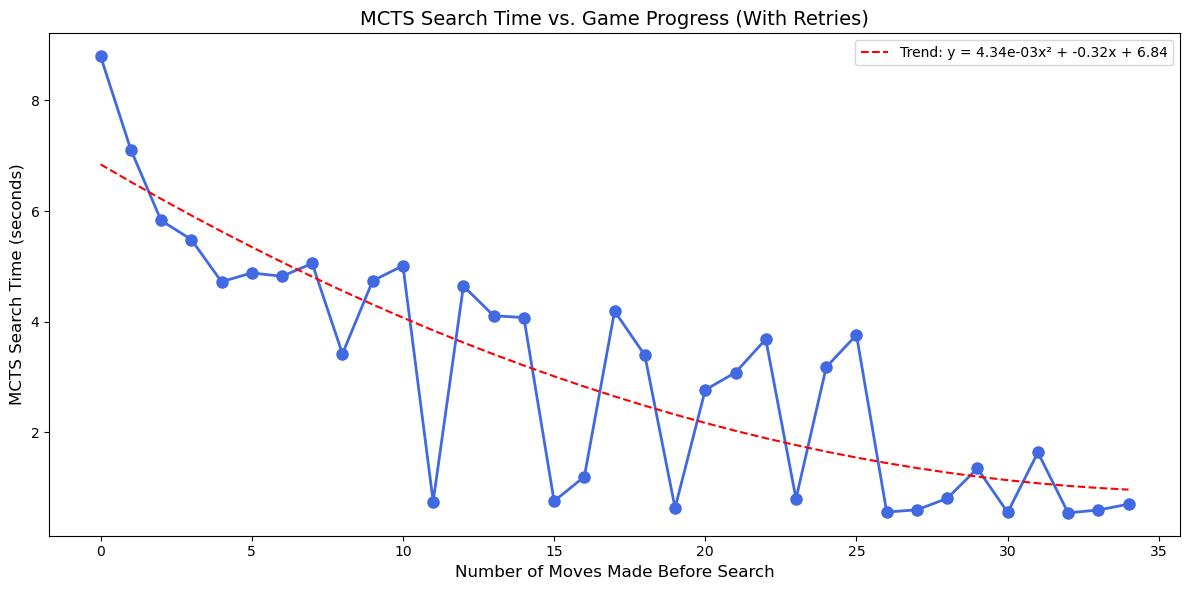

In [23]:
import matplotlib.pyplot as plt
import random
import time
import numpy as np
from mcts import MCTS  # Your MCTS implementation
from game import Bitboard  # Your Bitboard implementation

# Initialize MCTS
mcts = MCTS(100000)  # Adjust iterations as needed
time_per_move = []
move_counts = []

for target_moves in range(35):
    while True:
        board = Bitboard()
        
        # Make exactly 'target_moves' random moves (retry if game ends early)
        moves_made = 0
        for _ in range(target_moves):
            legal = board.get_legal_moves()
            if not legal or board.is_over():
                break  # Will retry
            board.make_move(random.choice(legal))
            moves_made += 1
        
        # Only proceed if we made all target moves
        if moves_made == target_moves and not board.is_over():
            break
    
    # Time the MCTS search
    start = time.time()
    best_move, stats = mcts.search(board)
    end = time.time()
    
    time_per_move.append(end - start)
    move_counts.append(target_moves)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(move_counts, time_per_move, 'o-', color='royalblue', linewidth=2, markersize=8)

# Formatting
plt.xlabel('Number of Moves Made Before Search', fontsize=12)
plt.ylabel('MCTS Search Time (seconds)', fontsize=12)
plt.title('MCTS Search Time vs. Game Progress (With Retries)', fontsize=14)

# Add trend line
z = np.polyfit(move_counts, time_per_move, 2)
p = np.poly1d(z)
plt.plot(move_counts, p(move_counts), 'r--', 
         label=f'Trend: y = {z[0]:.2e}x² + {z[1]:.2f}x + {z[2]:.2f}')
plt.legend(fontsize=10)

plt.xticks(np.arange(0, 36, 5))
plt.tight_layout()
plt.show()

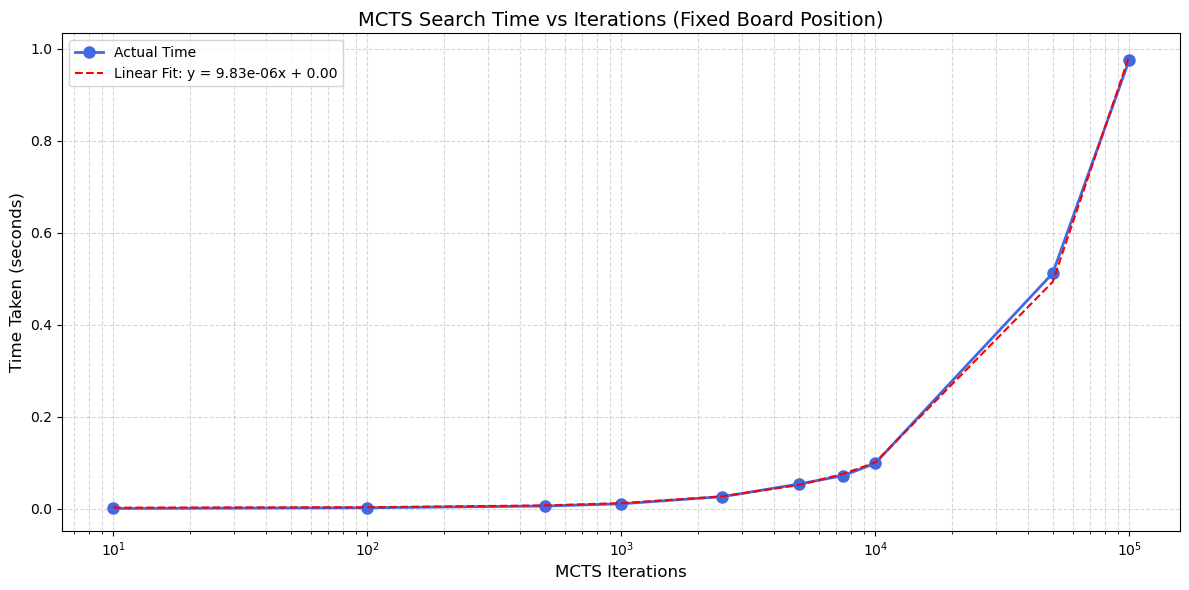

In [ ]:
import matplotlib.pyplot as plt
import time
import numpy as np
from mcts import MCTS  # Your MCTS implementation
from game import Bitboard  # Your Bitboard implementation

# Fixed Bitboard position
bitboard = Bitboard()
bitboard.player1 = 0b101110_0000001_0000100_0100111_0111000_0100110_0001011
bitboard.player2 = 0b010001_0000110_0111011_0011000_0000111_0011001_0000100
bitboard.height = [4,6,6,6,6,3,6]
bitboard.current_player = 2

# Test iterations
iterations = [10, 100, 500, 1000, 2500, 5000, 7500, 10000, 50000, 100000]
time_per_run = []

for it in iterations:
    mcts = MCTS(it)
    
    # Time the MCTS search
    start = time.perf_counter()  # More precise timing
    best_move, stats = mcts.search(bitboard)
    end = time.perf_counter()
    
    time_per_run.append(end - start)

# Plotting
plt.figure(figsize=(12, 6))

# Main plot
plt.plot(iterations, time_per_run, 'o-', color='royalblue', 
         linewidth=2, markersize=8, label='Actual Time')

# Trend line (linear fit)
z = np.polyfit(iterations, time_per_run, 1)
p = np.poly1d(z)
plt.plot(iterations, p(iterations), 'r--', 
         label=f'Linear Fit: y = {z[0]:.2e}x + {z[1]:.2f}')

# Formatting
plt.xlabel('MCTS Iterations', fontsize=12)
plt.ylabel('Time Taken (seconds)', fontsize=12)
plt.title('MCTS Search Time vs Iterations (Fixed Board Position)', fontsize=14)
plt.grid(True, which="both", linestyle='--', alpha=0.5)
plt.legend(fontsize=10)
plt.xscale('log')

plt.tight_layout()
plt.show()

### **3.2 Decision Trees (ID3)** ###

#### **3.2.1. Dataset Generation Libraries** ####

In [32]:
import csv
import random
from tqdm import tqdm
from game import Bitboard
from mcts import MCTS
import multiprocessing as mp
from multiprocessing import Pool
import os

#### **3.2.2. Dataset Generator** ####

In [33]:
def encode_board(board):
    # Positions of unused bits (0-based index)
    unused_bits = {5, 13, 20, 27, 34, 41}
            
    # Initialize the result array (41 positions)
    positions = [0] * 42    
    
    # Current position in the output array (0-based)
    pos_idx = 0
    
    # Iterate through all 48 bits (1-based)
    for i in range(48):
        if i in unused_bits:
            continue  # Skip unused bits
            
        p1_bit = (board.player1 >> i) & 1
        p2_bit = (board.player2 >> i) & 1
        if p1_bit:
            positions[pos_idx] = 1
        elif p2_bit:
            positions[pos_idx] = -1
  
        pos_idx += 1
    
    return positions

def worker_process(args):
    """Worker function that generates a single game sample"""
    mcts_iterations, min_random_moves, max_random_moves, process_id = args
    # Create MCTS instance per process to avoid sharing issues
    mcts = MCTS(mcts_iterations)
    
    board = Bitboard()
    # Make 0 to k random moves
     
    for _ in range(random.randint(min_random_moves, max_random_moves)):
        legal = board.get_legal_moves()
        if not legal or board.is_over():
            return (None, True)
        board.make_move(random.choice(legal))
    
    if board.is_over(): return (None, True)

    encoded = encode_board(board)
    move, _ = mcts.search(board.copy())
    return (encoded + [move], False)

def generate_dataset_parallel(n_games=1000, batch_size=500, mcts_iterations=10000, min_random_moves=8, max_random_moves=25):
    # Determine number of CPU cores to use e
    num_processes = mp.cpu_count()
    completed = 0
    terminated_early = 0

    # Create a pool of worker processes e
    with Pool(processes=num_processes) as pool:
        # Prepare arguments for each worker
        worker_args = [(mcts_iterations, min_random_moves, max_random_moves, i) for i in range(n_games)]
        
        # Open the output file  
        with open("dataset.csv", 'a', newline='') as f:
            writer = csv.writer(f)  
            if f.tell() == 0:  # File is empty
                writer.writerow([f"pos_{i}" for i in range(42)] + ["move"])
            
            buffer = []
            buffer_size = 0
            
            # Use imap_unordered for faster results as they become available
            with tqdm(total=n_games, desc="Generating Examples") as pbar:
                for result in pool.imap_unordered(worker_process, worker_args):
                    if result[1]: terminated_early += 1
                    elif result[0] is not None:

                        completed += 1

                        buffer.append(result[0])
                        buffer_size += 1
                        # Write in batches
                        if buffer_size >= batch_size:
                            writer.writerows(buffer)
                            buffer.clear()
                            buffer_size = 0


                    pbar.update(1)

                # Write remaining samples
                if buffer:
                    writer.writerows(buffer)

    print(f"Completed games: {completed} ({completed/n_games:.1%})")
    print(f"Terminated Early: {terminated_early} ({terminated_early/n_games:.1%})")

if __name__ == '__main__':
    # Required for Windows multiprocessing support
    generate_dataset_parallel(n_games=180000, batch_size=1000, min_random_moves=10, max_random_moves=30)


Generating Examples:   0%|          | 18/180000 [00:00<32:46, 91.52it/s]
Process ForkPoolWorker-8:
Process ForkPoolWorker-16:
Process ForkPoolWorker-11:
Process ForkPoolWorker-12:
Process ForkPoolWorker-3:
Process ForkPoolWorker-5:
Process ForkPoolWorker-2:
Process ForkPoolWorker-7:
Process ForkPoolWorker-4:
Process ForkPoolWorker-14:
Process ForkPoolWorker-6:
Process ForkPoolWorker-1:
Process ForkPoolWorker-10:
Process ForkPoolWorker-15:
Process ForkPoolWorker-9:
Process ForkPoolWorker-13:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (mos

KeyboardInterrupt: 

Since Connect4 states where represented by bitboards, conversion to an array (and then comma separated columns) is trivial and fast due to bitwise operations.
To further speed up the process we decided to implement multiprocessing, which had a great impact in the number of lines generated per second.
### **The parameters**
- `generate_dataset_parallel` has 5 arguments that all affect the iterations/s of the algorithm.
    - `n_games` is simply the ammount of iterations the algorithm does.
    - `batch_size` controls how many .csv lines are generated before writing them to the file.
        - The reason for this choice is that, besides being more efficient than writing line by line, or all at once, we can avoid problems with the algorithm being interrupted midway, thus losing all work done.
    - `mcts_iterations` is self explanatory and was left at 10000 for all generation done.
    - `min/max_random_moves` we decided to do K random moves before having MCTS make a move, we will explain this further later.
        - **Fun fact: there's a trade-off here:** 
        - if `min_random_moves` is too low, MCTS takes longer to decide moves (more steps during simulation and backpropagation).
        - If `max_random_moves` is too high, many games will end randomly before MCTS even gets a turn.
### Why Random Moves?
We start with K random moves to solve early-game bias:

- **Problem:** Pure MCTS always picks optimal openings (like center column), creating repetitive data.

- **Solution:** Random moves first ensure coverage of all 2,801 early states (0-4 moves).

- **Control:** By tuning K (e.g., 15-35 moves), we:

    - Keep later-game MCTS decisions intact

    - Focus on meaningful mid-game states

**Result:** Diverse but strategically relevant training data.


### 3.2.3 The dataset has 400000 lines. Let's analyze them.
The data in these graphs was obtained by terminal commands and imported manually, making them independent of the above code.
- `cut -d, -f43 dataset.csv | sort | uniq -c` - Ammount/Play made 

- `awk -F',' '{
    zeroes=0; 
    for(i=1;i<=NF;i++) if($i==0) zeroes++; 
    moves[42-zeroes]++
} 
END {
    for(m=0;m<=41;m++) 
        printf "%d,"(m in moves ? moves[m] : 0)
}' dataset.csv` - Ammount/Random moves made before MCTS

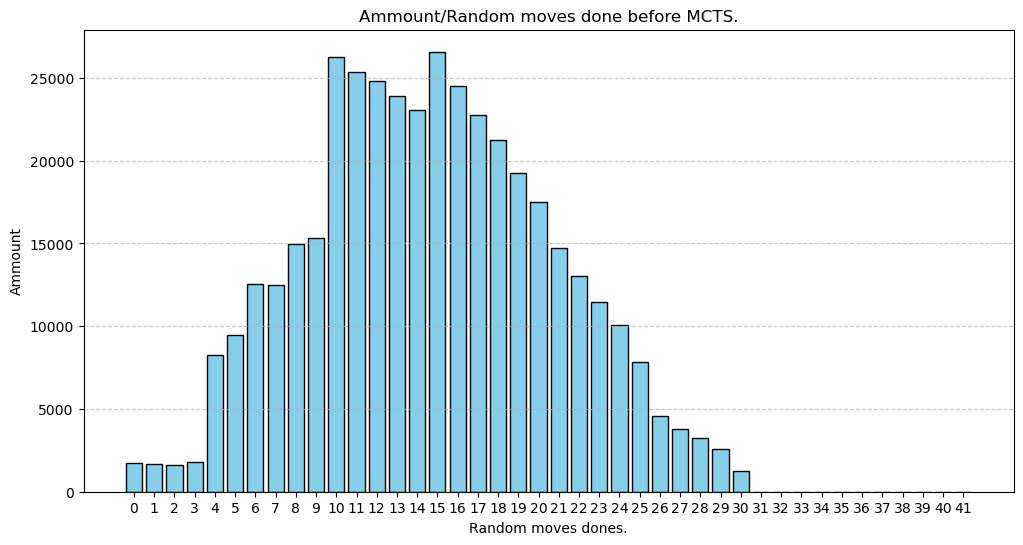

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

values = [1717,1680,1605,1821,8267,9463,12546,12506,14950,15334,26283,25349,24810,23938,23092,26583,24484,22782,21225,19233,17490,14746,13016,11456,10064,7867,4562,3788,3232,2573,1281,0,0,0,0,0,0,0,0,0,0,0]

positions = np.arange(42)

plt.figure(figsize=(12, 6))
plt.bar(positions, values, color='skyblue', edgecolor='black', width=0.8)

plt.xlabel('Random moves dones.')
plt.ylabel('Ammount')
plt.title('Ammount/Random moves done before MCTS.')
plt.xticks(positions)
plt.grid(axis='y', linestyle='--', alpha=0.7)

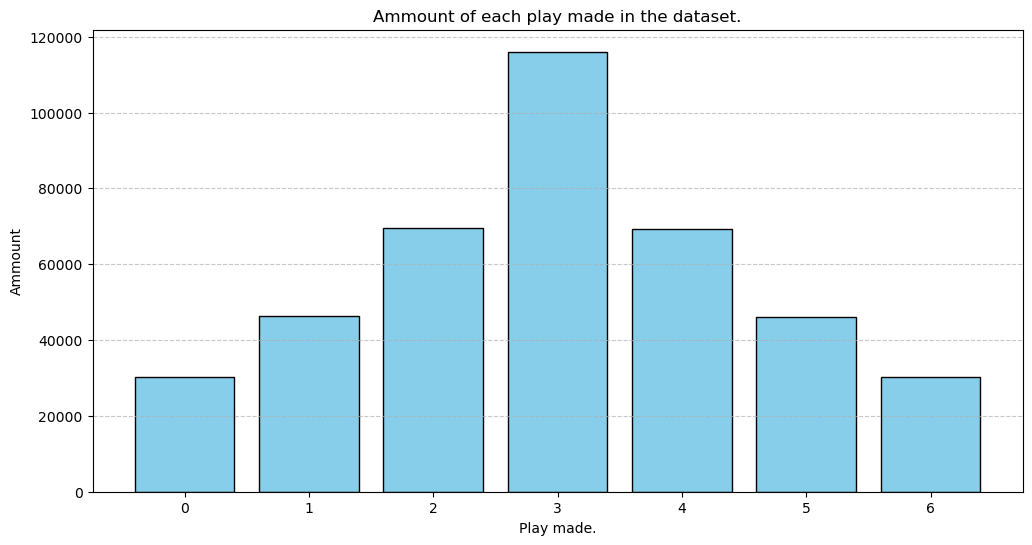

In [ ]:
values = [30149,46432,69433,116029,69360,46176,30164]

positions = np.arange(7)

plt.figure(figsize=(12, 6))
plt.bar(positions, values, color='skyblue', edgecolor='black', width=0.8)

plt.xlabel('Play made.')
plt.ylabel('Ammount')
plt.title('Ammount of each play made in the dataset.')
plt.xticks(positions) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

#### **3.2.4. ID3 Libraries** ####

In [4]:
import numpy as np

__NumPy__ is the only external library used in this implementation. It provides essential functionality for numerical operations, including:

- Efficient array manipulation and mathematical functions
- Statistical tools for counting and probability calculations
- Mathematical operations like logarithms used in entropy calculations


#### **3.2.5. Auxiliary Functions** ####

In [ ]:
def entropy(y):
    counts = np.bincount(y)
    probs = counts / len(y)
    return -np.sum([p * np.log2(p) for p in probs if p > 0])

def gini(y):
    counts = np.bincount(y)
    ps = counts / len(y)
    return 1 - np.sum(ps ** 2)

def information_gain(parent, left, right):
    weight_l = len(left) / len(parent)
    weight_r = len(right) / len(parent)
    return entropy(parent) - (weight_l * entropy(left) + weight_r * entropy(right))

def gini_gain(parent, left, right):
    weight_l = len(left) / len(parent)
    weight_r = len(right) / len(parent)
    return gini(parent) - (weight_l * gini(left) + weight_r * gini(right))  
 

The following function calculate:

- `entropy(y)`  
    - Calculates Shannon entropy, a measure of impurity in a set of labels
    - Uses np.bincount() to count occurrences of each class
    - Computes probability distribution by dividing counts by total number of samples
    - Returns the negative sum of p * log2(p) for each probability p
    - Higher entropy indicates more mixed classes (more impurity)


- `giny(y)`  
    - Calculates Gini impurity, an alternative measure of node impurity
    - Like entropy, starts by counting class occurrences and calculating probabilities
    - Returns 1 minus the sum of squared probabilities
    - A value of 0 indicates a pure node (all samples belong to the same class)
    - A higher value indicates more impurity


- `information_gain(parent, left, right)`
    - Measures the reduction in entropy achieved by splitting a parent node
    - Calculates weighted average entropy of child nodes (left and right)
    - Subtracts this from the parent entropy to determine information gain
    - Higher values indicate more informative splits


- `gini_gain(parent, left, right)`
    - Similar to information gain but uses Gini impurity instead of entropy
    - Measures the reduction in Gini impurity achieved by a split
    - Higher values indicate more effective splits



#### **3.2.6. ID3 Class Node** ####

In [ ]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature   
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        

The Node class represents elements in the decision tree structure:
- __Internal Nodes (decision nodes)__
    - `feature`: Index of the feature to test
    - `threshold`: Value to compare against
    - `left`: Child node for samples where feature ≤ threshold
    - `right`: Child node for samples where feature > threshold
    - `value`: None
    
- __Leaf nodes (prediction nodes)__
    - `feature`, `threshold`, `left`, `right`:None
    - `value`: The predicted class

This flexible design allows the same class to represent both decision points and final predictions.


#### **3.2.7. Class ID3DecisionTree** ####

In [1]:
class ID3DecisionTree:

    def __init__(self, max_depth=3, criterion='gini'):
        self.criterion = gini_gain if criterion == 'gini' else information_gain
        self.max_depth = max_depth
        self.root = None


    def fit(self, X, y):
        self.root = self.grow(X, y)
    
    def grow(self, X, y, depth=0):
        if len(set(y)) == 1 or depth >= self.max_depth: 
            return Node(value=np.bincount(y).argmax())  

        best_gain = -1
        best_feature, best_threshold = None, None
        best_left_mask, best_right_mask = None, None

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            if len(thresholds) > 10:
                thresholds = np.quantile(X[:, feature], [0.25, 0.5, 0.75])
            for t in thresholds:
                left_mask = X[:, feature] <= t   
                right_mask = ~left_mask

                if left_mask.sum() == 0 or right_mask.sum() == 0:
                    continue

                gain = self.criterion(y, y[left_mask], y[right_mask])

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = t
                    best_left_mask = left_mask
                    best_right_mask = right_mask

        if best_gain < 1e-6 or best_feature is None:  
            return Node(value=np.bincount(y).argmax())

        left = self.grow(X[best_left_mask], y[best_left_mask], depth + 1)
        right = self.grow(X[best_right_mask], y[best_right_mask], depth + 1)
        return Node(feature=best_feature, threshold=best_threshold, left=left, right=right)

    def predict(self, X):
        return np.array([self._predict(inputs, self.root) for inputs in X])

    def _predict(self, inputs, node):
        if node.value is not None:
            return node.value
        if inputs[node.feature] <= node.threshold:
            return self._predict(inputs, node.left)
        else:
            return self._predict(inputs, node.right)
        

The ID3DecisionTree class implements a modified version of the ID3 algorithm that handles numerical features. The constructor initializes:
- `criterion`: Function pointer to either gini_gain or information_gain
- `max_depth`: Maximum tree depth to prevent overfitting
- `root`: Will store the root node after training

__Methods:__

- `fit(self, x, y)`: Used as training method
    - The `fit` method trains the model by calling the recursive `grow` method and storing the resulting tree.

- `grow(self, x, y, depth=0)`: Used as Tree building method
    - The `grow` method recursively builds the decision tree through these steps:
        - **Check termination conditions:**
            - Stop if all samples belong to the same class
            - Stop if maximum depth is reached
            - In either case, create a leaf node with the most common class
        
        - **Find the optimal split:**
            - Evaluate each feature and potential threshold values
            - For features with many unique values, use quartiles to reduce computation
            - Calculate gain (information gain or Gini gain) for each split
            - Track the best feature-threshold combination
        
        - **Create the tree structure:**
            - If no good split is found, create a leaf node
            - Otherwise, recursively build left and right subtrees
            - Return a decision node with the optimal feature, threshold, and child nodes

- `predict(self, x)`: Applies the model to multiple samples, returning predictions as a NumPy array

- `_predict(self, inputs, node)`: Recursively traverses the tree for a single sample:
    - If at a leaf node, return the predicted class
    - If at a decision node, compare the feature value to the threshold
    - Follow the appropriate branch until reaching a leaf node

This implementation creates a complete decision tree classifier that handles numerical features, with options for different splitting criteria and depth control to prevent overfitting.





### **3.6.8. Testing ID3.**

In [9]:
import pandas as pd

def load_iris_data(filename):
    df = pd.read_csv(filename)
    
    class_map = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
    df['class'] = df['class'].map(class_map)
    
    feature_cols = ['sepallength', 'sepalwidth', 'petallength', 'petalwidth']
    
    X = df[feature_cols].values
    y = df['class'].values
    
    return X, y

def load_c4_dataset(path, size=None):
    # Load the CSV file
    df = pd.read_csv(path)

    X = df.drop(columns=['move']).values  # shape: (n_samples, 42)
    y = df['move'].values                 # shape: (n_samples,)
    
    return X[:size], y[:size]

def train_test_split(X, y, test_size=0.3, random_state=None):
    if random_state:
        np.random.seed(random_state)
    
    # Shuffle indices
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    
    # Calculate split point
    split = int((1 - test_size) * len(X))
    
    # Split data
    X_train = X[indices[:split]]
    X_test = X[indices[split:]]
    y_train = y[indices[:split]]
    y_test = y[indices[split:]]
    
    return X_train, X_test, y_train, y_test

def classification_report(y_true, y_pred, labels=None, target_names=None):

    if labels is None:
        labels = np.unique(np.concatenate((y_true, y_pred)))
    
    # Calculate metrics per class
    metrics = []
    for label in labels:
        true_pos = np.sum((y_true == label) & (y_pred == label))
        false_pos = np.sum((y_true != label) & (y_pred == label))
        false_neg = np.sum((y_true == label) & (y_pred != label))
        
        precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
        recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        support = np.sum(y_true == label)
        metrics.append((precision, recall, f1, support))

    max_name_len = max(len(str(name)) for name in (target_names or labels))
    header = f"{'':<{max_name_len}}  {'precision':>10}  {'recall':>10}  {'f1-score':>10}  {'support':>10}"
    report = [header]
    for i in labels:
        name = target_names[i] if target_names else str(label)
        p, r, f1, s = metrics[i]
        line = f"{name:<{max_name_len}}  {p:>10.2f}  {r:>10.2f}  {f1:>10.2f}  {s:>10}"
        report.append(line)

    report.extend([
        "\n",
        f"Accuracy: {np.mean(y_true == y_pred):.3f}"])

    return "\n".join(report)

funções para testar o ID3

In [8]:
from ID3 import ID3DecisionTree

X, y = load_iris_data('iris.csv')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=15, criterion='gini')
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print("Iris.csv test")
print("sklearn's ID3 classification report: \n")
print(classification_report(y_test, y_pred, target_names=["0", "1", "2", "3", "4", "5", "6"]))

tree = ID3DecisionTree(max_depth=15, criterion='gini')    
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print("Our ID3's classification report: \n")
print(classification_report(y_test, y_pred, target_names=["0", "1", "2", "3", "4", "5", "6"]))

Iris.csv test
sklearn's ID3 classification report: 

    precision      recall    f1-score     support
0        1.00        1.00        1.00          10
1        0.94        1.00        0.97          17
2        1.00        0.94        0.97          18


Accuracy: 0.978
gini_gain
Our ID3's classification report: 

    precision      recall    f1-score     support
0        1.00        1.00        1.00          10
1        0.89        1.00        0.94          17
2        1.00        0.89        0.94          18


Accuracy: 0.956


Explicar que estamos a testar o ID3 com o iris.csv, e mostrar a comparação da nossa accuracy com a do sklearn

gini_gain
gini_gain
gini_gain
gini_gain
gini_gain
gini_gain
gini_gain
gini_gain
gini_gain


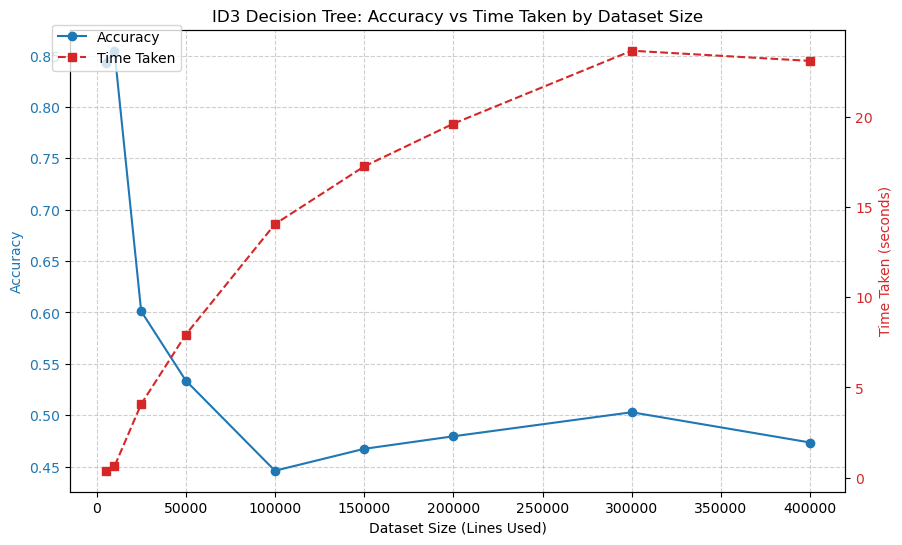

In [7]:
import matplotlib.pyplot as plt
from ID3 import ID3DecisionTree
from time import time

accuracy = []
time_taken = []
lines_used = [5000, 10000, 25000, 50000, 100000, 150000, 200000, 300000, 400000]

for n in lines_used:
    X, y = load_c4_dataset('dataset.csv', n)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    start = time()
    tree = ID3DecisionTree(max_depth=15, criterion='gini')    
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    end = time()

    time_taken.append(end - start)
    accuracy.append(np.mean(y_test == y_pred))

fig, ax1 = plt.subplots(figsize=(10, 6))

# Accuracy (left axis)
ax1.set_xlabel('Dataset Size (Lines Used)')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.plot(lines_used, accuracy, 'o-', color='tab:blue', label='Accuracy')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, linestyle='--', alpha=0.6)

# Time (right axis)
ax2 = ax1.twinx()
ax2.set_ylabel('Time Taken (seconds)', color='tab:red')
ax2.plot(lines_used, time_taken, 's--', color='tab:red', label='Time Taken')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and legend
plt.title('ID3 Decision Tree: Accuracy vs Time Taken by Dataset Size')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()

gini_gain
gini_gain
gini_gain
gini_gain
gini_gain
gini_gain
gini_gain


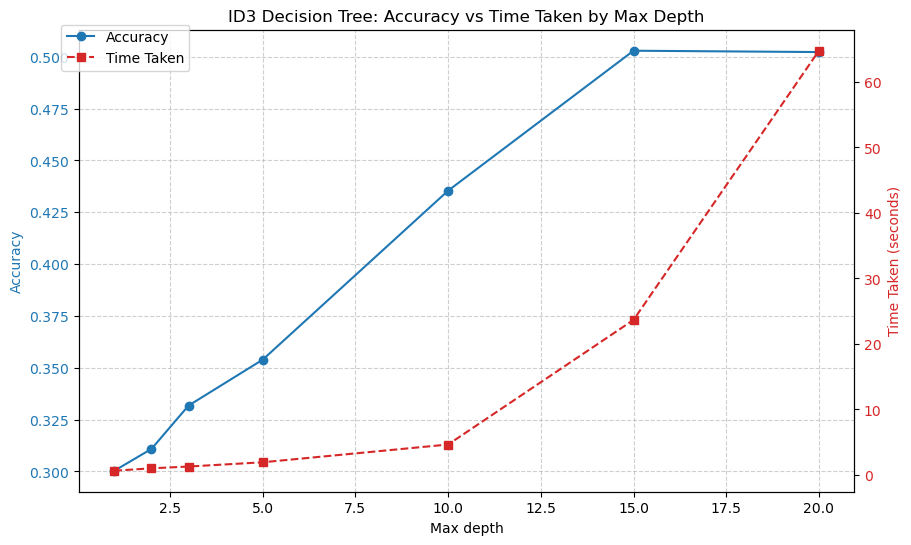

In [11]:
import matplotlib.pyplot as plt
from ID3 import ID3DecisionTree
from time import time

accuracy = []
time_taken = []
depth = [1,2,3,5,10,15,20]

for n in depth:
    X, y = load_c4_dataset('dataset.csv', 300000)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    start = time()
    tree = ID3DecisionTree(max_depth=n, criterion='gini')    
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    end = time()

    time_taken.append(end - start)
    accuracy.append(np.mean(y_test == y_pred))

fig, ax1 = plt.subplots(figsize=(10, 6))

# Accuracy (left axis)
ax1.set_xlabel('Max depth')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.plot(depth, accuracy, 'o-', color='tab:blue', label='Accuracy')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, linestyle='--', alpha=0.6)

# Time (right axis)
ax2 = ax1.twinx()
ax2.set_ylabel('Time Taken (seconds)', color='tab:red')
ax2.plot(depth, time_taken, 's--', color='tab:red', label='Time Taken')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and legend
plt.title('ID3 Decision Tree: Accuracy vs Time Taken by Max Depth')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()


In [12]:
import matplotlib.pyplot as plt
from ID3 import ID3DecisionTree
from time import time

X, y = load_c4_dataset('dataset.csv', 300000)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Gini vs Entropy, using 300000 lines of dataset and 15 depth.")

start = time()
tree = ID3DecisionTree(max_depth=15, criterion='gini')    
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
end = time()

print(f"Gini time taken: {end-start}")
print(f"Gini accuracy: {np.mean(y_test == y_pred):.3f}")

start = time()
tree = ID3DecisionTree(max_depth=n, criterion='entropy')    
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
end = time()

print(f"Entropy time taken: {end-start}")
print(f"Entropy accuracy: {np.mean(y_test == y_pred):.3f}")

Gini vs Entropy, using 300000 lines of dataset and 15 depth.
gini_gain
Gini time taken: 26.175994157791138
Gini accuracy: 0.503
information_gain
Entropy time taken: 80.93076682090759
Entropy accuracy: 0.475


## **4. Connect Four Algorithms Implementation** ##

### **4.1. Libraries** ###


In [ ]:
import game
import mcts
from pygame import gfxdraw
import pygame
from os import environ
import time
environ['PYGAME_HIDE_SUPPORT_PROMPT'] = '1'

### **4.2. Main** ###


In [ ]:
def draw_statistics(stats):
    pygame.font.init()  # you have to call this at the start,
    # if you want to use this module.
    my_font = pygame.font.SysFont('Helvetica', 39)
    for x in range(7):
        visits = stats[x]/iterations
        wins = stats[7+x]/iterations
        pygame.draw.rect(screen, (229, 192, 123), pygame.Rect(
            740 + 95*x, 562 - 540 * visits, 70, 540 * visits))
        pygame.draw.rect(screen, (85, 104, 79), pygame.Rect(
            740 + 95*x, 562 - 540 * wins, 70, 540 * wins))

        text_surface = my_font.render("{:.2f}".format(
            visits), True, (229, 192, 123), (39, 56, 73))
        textRect = text_surface.get_rect()
        textRect.center = (772 + 96 * x, 600)
        screen.blit(text_surface, textRect)

        text_surface = my_font.render("{:.2f}".format(
            wins), True, (85, 104, 79), (39, 56, 73))
        textRect = text_surface.get_rect()
        textRect.center = (772 + 96 * x, 640)
        screen.blit(text_surface, textRect)

        text_surface = my_font.render(
            str(x+1), True, (255, 255, 255), (39, 56, 73))
        textRect = text_surface.get_rect()
        textRect.center = (772 + 96 * x, 680)
        screen.blit(text_surface, textRect)

        draw_circle(screen, 50, 660, 20, (229, 192, 123))
        text_surface = my_font.render(
            "Visits", True, (229, 192, 123), (39, 56, 73))
        textRect = text_surface.get_rect()
        textRect.center = (120, 660)
        screen.blit(text_surface, textRect)

        draw_circle(screen, 200, 660, 20, (85, 104, 79))
        text_surface = my_font.render(
            "Wins", True, (85, 104, 79), (39, 56, 73))
        textRect = text_surface.get_rect()
        textRect.center = (270, 660)
        screen.blit(text_surface, textRect)

        text_surface = my_font.render(
            "Iterations: " + str(iterations), True, (255, 255, 255), (39, 56, 73))
        textRect = text_surface.get_rect()
        textRect.center = (525, 660)
        screen.blit(text_surface, textRect)


def draw_circle(surface, x, y, radius, color):
    gfxdraw.aacircle(surface, x, y, radius, color)
    gfxdraw.filled_circle(surface, x, y, radius, color)


def drawGrid(mat):
    mouse_x, mouse_y = pygame.mouse.get_pos()
    for x in range(7):
        background = (16, 27, 39)
        if (mouse_x // 100) == x:
            background = (28, 39, 51)
        for y in range(6):
            if mat[5 - y][x] == 0:
                draw_circle(screen, 100*x+60, 100*y+60, 45, background)
            elif mat[5 - y][x] == 1:
                draw_circle(screen, 100*x+60, 100*y+60, 45, (24, 188, 156))
            elif mat[5 - y][x] == 2:
                draw_circle(screen, 100*x+60, 100*y+60, 45, (238, 102, 119))


def main():
    bitboard = game.Bitboard()

    #bitboard.player1 = 0b0000000000000100010100010101001010100000000000000
    #bitboard.player2 = 0b0000000000000000001010101010000101000000010000000
    #bitboard.height = [0, 1, 5, 6, 4, 1, 0]
    #bitboard.current_player = 2
    #player_move = -1

    bitboard.player1 = 0b101110_0000001_0000100_0100111_0111000_0100110_0001011
    bitboard.player2 = 0b010001_0000110_0111011_0011000_0000111_0011001_0000100
    bitboard.height = [4,6,6,6,6,3,6]
    bitboard.current_player = 2
    player_move = -1

    global iterations
    iterations = int(input("How many iterations?: "))
    bot = mcts.MCTS(iterations)
    running = True
    global screen
    pygame.init()
    running = True
    WINDOW_HEIGHT = 6 * 100 + 20 + 100
    WINDOW_WIDTH = 7 * 100 + 20 + 680
    screen = pygame.display.set_mode((WINDOW_WIDTH, WINDOW_HEIGHT))
    stats = [0] * 14
    while not bitboard.is_over() and running:

        if bitboard.current_player == 2:
            print("AI is thinking...")
            start = time.time()
            best_move, stats = bot.search(bitboard)
            end = time.time()
            print(f"Took {end - start} seconds.")
            bitboard.make_move(best_move)

        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_q:
                    running = False
            if event.type == pygame.MOUSEBUTTONUP:
                mouse_x, mouse_y = pygame.mouse.get_pos()
                player_move = mouse_x // 100
                if player_move <= 6:
                    bitboard.make_move(player_move)

        screen.fill((39, 56, 73))
        drawGrid(bitboard.matrix())
        draw_statistics(stats)
        pygame.display.update()

        if bitboard.check_player_win(1):
            print("Congratulations! You win!")
            time.sleep(4)
            return
        elif bitboard.check_player_win(2):
            print("AI wins. Better luck next time!")
            time.sleep(4)
            return
        elif bitboard.is_over():
            print("It's a draw!'")
            time.sleep(4)
            return


main()


## **5. User Interface Game** ##


### **5.1. Human vs Human** ###


### **5.2. Human vs MCTS** ###


### **5.3. Human vs ID3** ###


### **5.4. MCTS vs ID3** ###


## **6. Results** ##


## **7. Conclusion** ##
